In [ ]:
import pandas as pd
import networkx as nx

# This script builds a directed football transfer network graph from the dataset, mapping clubs and leagues, 
# and exports it as a GEXF file for visualization in Gephi. Used only for visualization purposes.

# Load dataset
data = pd.read_excel("Transfer-Players-Clubs.xlsx", engine="openpyxl")

# Create a dictionary to store club_id → league mapping
club_league_map = {}

# Fill the dictionary with unique clubs
for _, row in data.iterrows():
    club_id = row['from_club_id']
    league = row['domestic_competition_id']
    if pd.notna(club_id) and pd.notna(league):
        club_league_map[club_id] = league

    club_id = row['to_club_id']
    if pd.notna(club_id) and pd.notna(league):
        club_league_map[club_id] = league

# Initialize directed graph
G = nx.DiGraph()

# Iterate over rows to add nodes and edges
for _, row in data.iterrows():
    from_club_id = row['from_club_id']
    to_club_id = row['to_club_id']
    player_name = row['player_name']
    player_id = row['player_id']
    market_value = row['market_value_in_eur_x'] if not pd.isna(row['market_value_in_eur_x']) else 0

    # Ensure both clubs exist in the graph before adding edges
    if from_club_id not in G:
        G.add_node(from_club_id, league=club_league_map.get(from_club_id, "Unknown"))

    if to_club_id not in G:
        G.add_node(to_club_id, league=club_league_map.get(to_club_id, "Unknown"))

    # Add edges with transfer attributes
    G.add_edge(from_club_id, to_club_id, 
               player_name=player_name, 
               player_id=player_id,
               weight= market_value)  

# Export graph to Gephi-compatible format
nx.write_gexf(G, "football_transfer_graph_final.gexf")

print("GEXF file has been created: football_transfer_graph_final")


GEXF file has been created: football_transfer_graph_final



## Research Question:
### What are the strongest and most active transfer pathways between the most connected clubs in the network?

This section analyzes the strongest transfer pathways between the top connected clubs using degree centrality and edge weights. It includes subgraph visualization, edge weight analysis, and null model comparison.


In [ ]:


import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import random
import numpy as np


In [ ]:

# Load Transfer Network
# Load as directed multigraph to track repeated transfers
multi_G = nx.read_edgelist("edge_list_whole_network.txt", create_using=nx.MultiDiGraph(), nodetype=int)

# Convert to standard DiGraph with edge weights representing transfer frequency
G = nx.DiGraph()
edge_weights = Counter((u, v) for u, v in multi_G.edges())
for (u, v), w in edge_weights.items():
    G.add_edge(u, v, weight=w)

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


Nodes: 3139, Edges: 22264


In [ ]:

# Select Top N Clubs by Degree
N = 10
top_clubs = [node for node, _ in sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:N]]
subG = G.subgraph(top_clubs).copy()


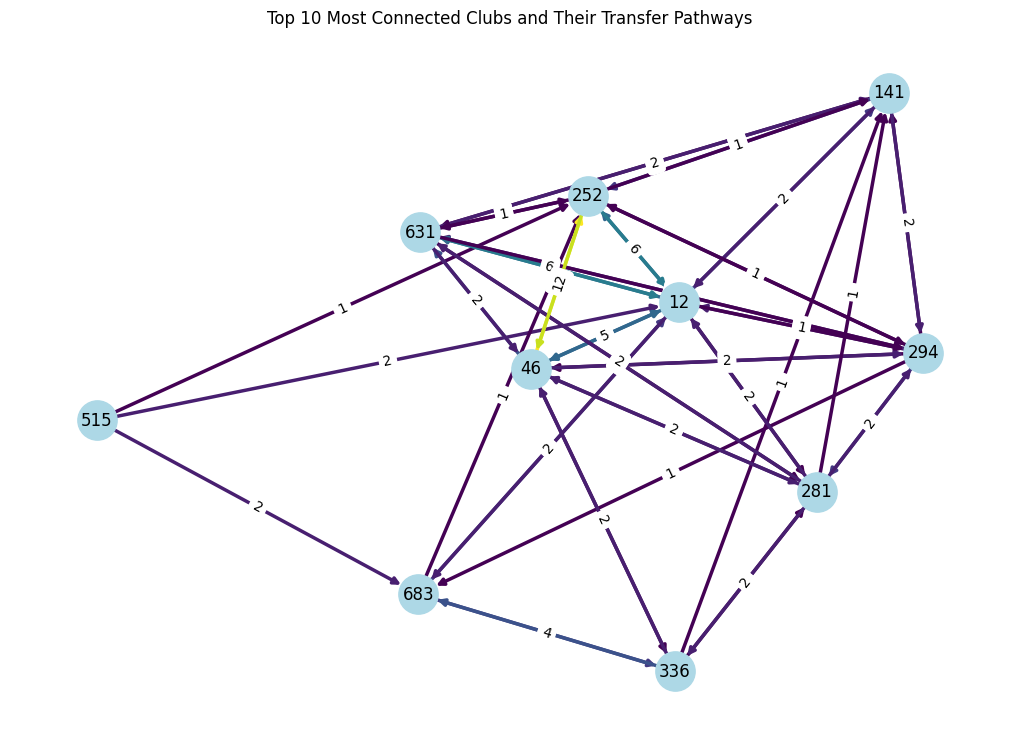

In [ ]:

# Visualize Subgraph of Top Clubs
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(subG, seed=42)
edge_weights = [subG[u][v]['weight'] for u, v in subG.edges()]
nx.draw(subG, pos, with_labels=True, node_size=800, node_color="lightblue",
        edge_color=edge_weights, width=2.5, edge_cmap=plt.cm.viridis, arrows=True)
nx.draw_networkx_edge_labels(subG, pos, edge_labels={(u, v): d['weight'] for u, v, d in subG.edges(data=True)})
plt.title("Top 10 Most Connected Clubs and Their Transfer Pathways")
plt.show()


In [ ]:

#Strongest Transfer Pathways Among Top Clubs
print("Top 10 Transfer Pathways Between Top Clubs (by frequency):")
strongest = sorted(subG.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]
for u, v, data in strongest:
    print(f"{u} → {v}: {data['weight']} transfers")


Top 10 Transfer Pathways Between Top Clubs (by frequency):
46 → 252: 13 transfers
252 → 46: 12 transfers
631 → 12: 6 transfers
252 → 12: 6 transfers
12 → 46: 5 transfers
12 → 631: 5 transfers
12 → 252: 5 transfers
46 → 12: 5 transfers
46 → 631: 4 transfers
336 → 683: 4 transfers


In [ ]:

# Null Model - Degree-Preserving Randomization for Directed Graphs

def generate_random_directed_graph(G, swaps=5, tries=100):
    randomized = G.copy()
    try:
        nx.directed_edge_swap(
            randomized,
            nswap=swaps * randomized.number_of_edges(),
            max_tries=tries * randomized.number_of_edges()
        )
    except nx.NetworkXError as e:
        print(f"Swap failed: {e}")
    return randomized

def clustering_and_pathlength(G):
    if nx.is_strongly_connected(G):
        avg_path = nx.average_shortest_path_length(G)
    else:
        largest_scc = max(nx.strongly_connected_components(G), key=len)
        subgraph = G.subgraph(largest_scc)
        avg_path = nx.average_shortest_path_length(subgraph)
    return nx.average_clustering(G.to_undirected()), avg_path

# Run 1000 randomized networks
null_clustering = []
null_path_lengths = []

for i in range(1000):
    randG = generate_random_directed_graph(G)
    c, p = clustering_and_pathlength(randG)
    null_clustering.append(c)
    null_path_lengths.append(p)

# Real network stats
real_clust, real_path = clustering_and_pathlength(G)
print(f"Real Network Clustering: {real_clust:.4f}, Avg. Path Length: {real_path:.4f}")
print(f"Null Model Clustering: Mean={np.mean(null_clustering):.4f}, Std={np.std(null_clustering):.4f}")
print(f"Null Model Path Length: Mean={np.mean(null_path_lengths):.4f}, Std={np.std(null_path_lengths):.4f}")


Real Network Clustering: 0.2046, Avg. Path Length: 2.3534
Null Model Clustering: Mean=0.1088, Std=0.0030
Null Model Path Length: Mean=2.1605, Std=0.0036


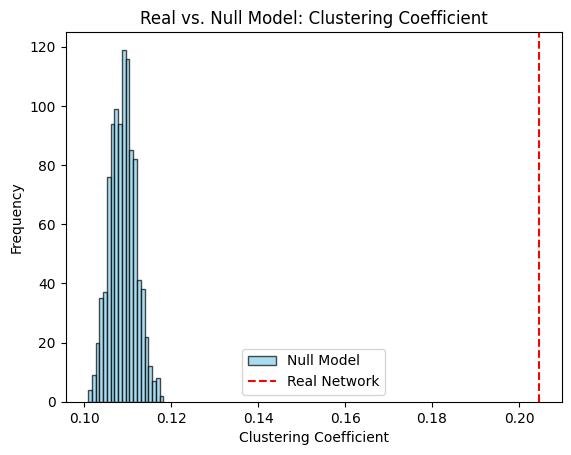

In [ ]:

# Histogram of Clustering Coefficient from Null Model
plt.hist(null_clustering, bins=20, color="skyblue", edgecolor="black", alpha=0.7, label="Null Model")
plt.axvline(real_clust, color='red', linestyle='--', label="Real Network")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.title("Real vs. Null Model: Clustering Coefficient")
plt.legend()
plt.show()
